<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Text Classification

Text classification is one of the most common tasks in NLP and can be used for applications
such as tagging customer feedback into categories or routing support tickets according to their
language. Chances are that your email’s spam filter is using text classification to protect your
inbox from a deluge of unwanted junk!

Another common type of text classification is sentiment analysis, which aims to identify the
polarity of a given text.

Now imagine that you are a data scientist who needs to build a system that can automatically
identify emotional states such as “anger” or “joy” that people express towards your company’s
product on Twitter. 

Until 2018, the deep learning approach to this problem typically involved
finding a suitable neural architecture for the task and training it from scratch on a dataset of
labeled tweets. This approach suffered from three major drawbacks:

- You needed a lot of labeled data to train accurate models like recurrent or convolutional neural networks.
- Training these models from scratch was time consuming and expensive.
- The trained model could not be easily adapted to a new task, e.g. with a different set of labels.

Nowadays, these limitations are largely overcome via transfer learning, where typically a
Transformer-based architecture is pretrained on a generic task such as language modeling and
then reused for a wide variety of downstream tasks.

##Setup

In [ ]:
!pip -q install transformers[sentencepiece]
!pip -q install datasets

In [ ]:
!pip -q install umap-learn

In [48]:
from transformers import pipeline
from transformers import set_seed
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

from datasets import list_datasets, load_dataset

import torch
from torch.nn.functional import cross_entropy

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  display_cm.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

##Dataset

To build our emotion detector we’ll use a great dataset from an article that explored how
emotions are represented in English Twitter messages. 

Unlike most sentiment analysis datasets
that involve just “positive” and “negative” polarities, this dataset contains six basic emotions:
anger, disgust, fear, joy, sadness, and surprise. 


Given a tweet, our task will be to train a model
that can classify it into one of these emotions!

In [5]:
# We can use the list_datasets function to see what datasets are available in the Hub:
datasets = list_datasets()

print(f"There are {len(datasets)} datasets currently available on the Hub.")
print(f"The first 10 are: {datasets[:10]}")

There are 36641 datasets currently available on the Hub.
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [ ]:
emotions = load_dataset("emotion")

In [7]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. 

And just like any dictionary, we can access an individual split as usual

In [8]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [9]:
len(train_ds)

16000

In [10]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [11]:
train_ds.column_names

['text', 'label']

We can see what data types are being used under the hood by accessing the
features attribute of a Dataset object:

In [12]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [13]:
train_ds[:6]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was'],
 'label': [0, 0, 3, 2, 3, 0]}

In [14]:
train_ds["text"][:6]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was']

Although Datasets provides a lot of low-level functionality to slice and dice our data, it is often
convenient to convert a Dataset object to a Pandas DataFrame so we can access highlevel
APIs for data visualization. 

In [15]:
emotions.set_format(type="pandas")

df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


However, the labels are represented as integers so let’s create a new column in our DataFrame with the
corresponding label names:

In [16]:
def label_int2str(row, split):
  return emotions[split].features["label"].int2str(row)

In [17]:
df["label_name"] = df["label"].apply(label_int2str, split="train")
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Whenever you are working on text classification problems, it is a good idea to examine the
distribution of examples among each class. 


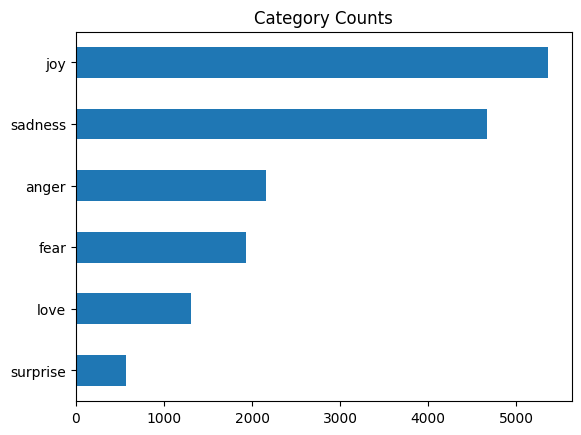

In [18]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Category Counts");

We can see that the dataset is heavily imbalanced; the joy and sadness classes appear
frequently whereas love and sadness are about 5-10 times rarer.

There are several ways to
deal with imbalanced data:

* Randomly oversample the minority class.
* Randomly undersample the majority class.
* Gather more labeled data from the underrepresented classes.

If you want to learn more about these sampling techniques, just
check out the [Imbalanced-learn library](https://imbalanced-learn.org/stable/index.html).

Transformer models have a maximum input sequence length that is referred to as the maximum context size. 

For most applications with BERT, the maximum context size is 512 tokens, where
a token is defined by the choice of tokenizer and can be a word, subword, or character. 

Let’s make a rough estimate of our tweet lengths per emotion by looking at the distribution of words per tweet:

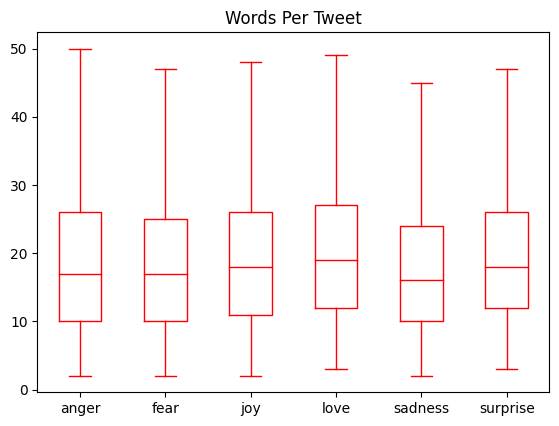

In [19]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)

df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="red", )
plt.suptitle("")
plt.xlabel("");

From the plot we see that for each emotion, most tweets are around 15 words long and the
longest tweets are well below BERT’s maximum context size of 512 tokens. 

Texts that are
longer than a model’s context window need to be truncated, which can lead to a loss in
performance if the truncated text contains crucial information. 

Let’s now figure out how we can
convert these raw texts into a format suitable for Transformers!

But before going ahead, let’s also reset the output
format of our dataset since we don’t need the DataFrame format anymore:

In [20]:
emotions.reset_format()

##Tokenization

Transformer models like BERT can not receive raw strings as input; instead they assume the
text has been tokenized into numerical vectors. Tokenization is the step of breaking down a
string into the atomic units used in the model. 


In [21]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

We can examine a few attributes of the tokenizer such as the vocabulary size:

In [22]:
tokenizer.vocab_size

30522

We can also look at the special tokens used by the tokenizer, which differ from model to model.

For example, BERT uses the `[MASK]` token for the primary objective of masked language
modeling and the `[CLS]` and `[SEP]` tokens for the secondary pretraining objective of
predicting if two sentences are consecutive:

In [23]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

Furthermore, the tokenizer stores the information of the corresponding model’s maximum
context sizes:

In [24]:
tokenizer.model_max_length

512

Lets examine how the encoding and decoding of strings works in practice by first encoding a
test string:

In [25]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Now that we have the
`input_ids`, we can convert them back into tokens by using the tokenizer’s
`convert_ids_to_tokens()` method:

In [26]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


The AutoTokenizer class has a `convert_tokens_to_string()` method for
remove the prefix etc., so let’s apply it to our tokens:

In [27]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


To tokenize the whole corpus, we'll use the `map()` method of our `DatasetDict` object.It provides a convenient way to apply a processing function to each element in a dataset.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [28]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

To see `tokenize()` in action, let's pass a batch of two examples from the training set:

In [29]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


These zeros have a corresponding `[PAD]` token in the vocabulary, and the set of special tokens also includes the `[CLS]` and `[SEP]` tokens that we encountered earlier:

In [30]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x: x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


Let's pply it across all the splits in the
corpus.

In [31]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

We can see that this operation has added new `input_ids` and `attention_mask` columns to the dataset:

In [32]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


##Training a Text Classifier

As we know, models like DistilBERT are pretrained to predict masked words in a sequence of text. However, we can't use these language models directly for text classification; we need to modify them slightly.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/chapter02_encoder-classifier.png?raw=1'/>

First, the text is tokenized and represented as one-hot vectors whose dimension is the size of
the tokenizer vocabulary, usually consisting of 50k-100k unique tokens. 

Next, these token
encodings are embedded in lower dimensions and passed through the encoder block layers to
yield a hidden state for each input token. 

For the pretraining objective of language modeling,
each hidden state is connected to a layer that predicts the token for the input token. 

Just like this.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/embedding_layer.png?raw=1'/>

For the classification task, we replace the
language modeling layer with a classification layer. 


We have two options to train such a model on our Twitter dataset:
- **Feature extraction**
  - We use the hidden states as features and just train a classifier on them.
- **Fine-tuning**
  - We train the whole model end-to-end, which also updates the parameters of the pretrained BERT model.

###Feature Extractors

To use a Transformer as a feature extractor is fairly simple;we freeze
the body’s weights during training and use the hidden states as features for the classifier. 

The advantage of this approach is that we can quickly train a small or shallow model. Such a model
could be a neural classification layer or a method that does not rely on gradients such a Random Forest. 

This method is especially convenient if GPUs are unavailable since the hidden
states can be computed relatively fast on a CPU.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/2.png?raw=1' width='800'/>

>In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier


####Pretrained Models

Let's load the DistilBERT checkpoint:

In [ ]:
model = AutoModel.from_pretrained(model_name).to(device)

The `AutoModel` class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. 

####Last Hidden States

To warm up, let’s retrieve the last hidden states for a single string. 

In [34]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


Now that we have the encodings as a tensor, the final step is to
place them on the same device as the model and pass the inputs as follows:

In [35]:
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


The current model returns only one attribute, which is the last hidden state, so let’s examine its shape:

In [36]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

For classification tasks, it is common
practice to just use the hidden state associated with the `[CLS]` token as the
input feature. 

Since this token appears at the start of each sequence, we can
extract it by simply indexing into `outputs.last_hidden_state` as follows:

In [37]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

Now we know how to get the last hidden state for a single string; let’s do the
same for the whole dataset by creating a new `hidden_state` column that
stores all these vectors.

In [38]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

Since our model expects tensors as inputs, the next thing to do is convert the
`input_ids` and `attention_mask` columns to the "torch" format, as
follows:

In [39]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

We can then go ahead and extract the hidden states across all splits in one go:

In [40]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Notice that we did not set `batch_size=None` in this case, which means the
default `batch_size=1000` is used instead. 

As expected, applying the
`extract_hidden_states()` function has added a new `hidden_state`
column to our dataset:

In [41]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Now that we have the hidden states associated with each tweet, the next step
is to train a classifier on them. 

####Feature Matrix

The preprocessed dataset now contains all the information we need to train a clasifier on it. We
will use the hidden states as input features and the labels as targets. 

We can easily create the
corresponding arrays in the well known Scikit-Learn format as follows:

In [43]:
x_train = np.array(emotions_hidden["train"]["hidden_state"])
x_valid = np.array(emotions_hidden["validation"]["hidden_state"])

y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

x_train.shape, x_valid.shape

((16000, 768), (2000, 768))

####Visualizing training set

Before we train a model on the hidden states, it is good practice to perform a sanity check that
they provide a useful representation of the emotions we want to classify. 

Since visualising the hidden states in 768 dimensions is tricky to say the least, we’ll use the powerful UMAP algorithm to project the vectors down to 2D. 

Since UMAP works best when the features are scaled to lie in the `[0,1]` interval, we’ll first apply a MinMaxScaler and then use UMAP to
reduce the hidden states:

In [44]:
x_scaled = MinMaxScaler().fit_transform(x_train)
# Initialize and fit UMAP
mapper = umap.UMAP(n_components=2, metric="cosine").fit(x_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

df_emb.head()

,X,Y,label
0,4.331319,6.385790,0
1,-2.736841,6.269521,0
2,5.101747,2.788971,3
3,-2.295396,3.857513,2
4,-3.072382,4.271702,3


Let us investigate the compressed data a little bit further and
plot the density of points for each category separately:

In [45]:
labels= emotions_encoded["train"].features["label"]
labels.names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

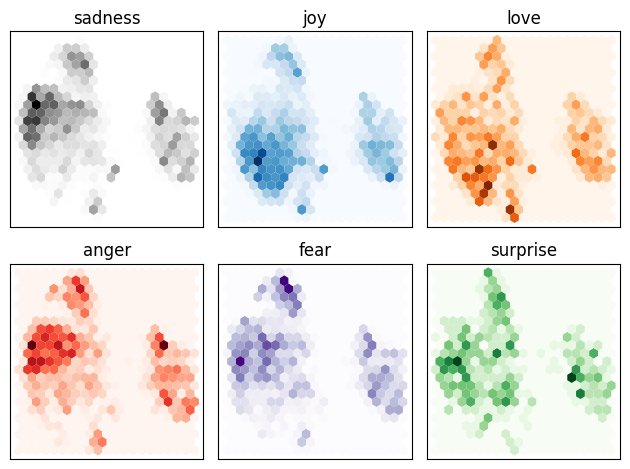

In [46]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels= emotions_encoded["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

Now there seem to be clearer patterns; the negative feelings such as sadness, anger and
fear all occupy a similar regions with slightly varying distributions. 

On the other hand, joy
and love are well separated from the negative emotions and also share a similar space.

Finally, surprise is scattered all over the place. 

We hoped for some separation but this in no
way guaranteed since the model was not trained to know the difference between this emotions
but learned them implicitly by predicting missing words.

####Training Simple Classifier

Let’s use these hidden states to train a simple
logistic regressor with Scikit-Learn! 

Training such a simple model is fast and does not require a GPU:

In [47]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(x_train, y_train)
lr_clf.score(x_valid, y_valid)

0.633

By looking at the accuracy it might appear that our model is just a bit better than random, but
since we are dealing with an unbalanced multiclass dataset this is significantly better than
random. 

We can get a better feeling for whether our model is any good by comparing against a
simple baseline.

In Scikit-Learn there is a `DummyClassifier` that can be used to build a
classifier with simple heuristics such as always choose the majority class or always draw a random class. 

In this case the best performing heuristic is to always choose the most frequent class:

In [50]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
dummy_clf.score(x_valid, y_valid)

0.352

So our simple classifier with BERT embeddings is
significantly better than our baseline.

We can further investigate the performance of the model
by looking at the confusion matrix of the classifier, which tells us the relationship between the
true and predicted labels:

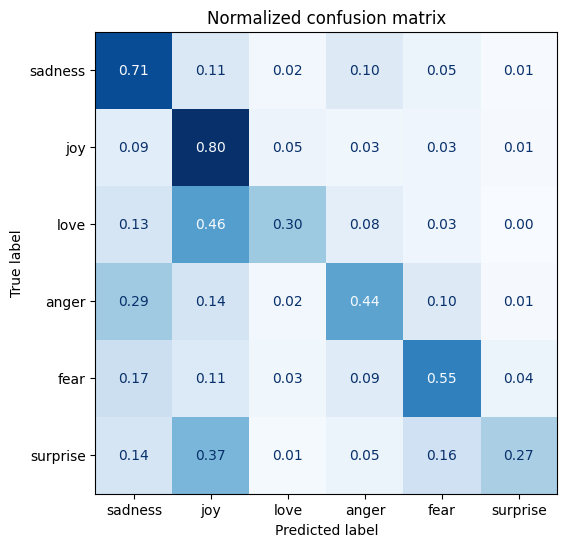

In [51]:
y_preds = lr_clf.predict(x_valid)

plot_confusion_matrix(y_preds, y_valid, labels)

We can see that anger and fear are most often confused with sadness, which agrees with
the observation we made when visualizing the embeddings. Also love and surprise are
frequently mistaken for joy.

To get an even better picture of the classification performance we can look at the precision, recall and F1-score for each class:

In [52]:
print(classification_report(y_valid, y_preds, target_names=labels))

              precision    recall  f1-score   support

     sadness       0.65      0.71      0.68       550
         joy       0.71      0.80      0.75       704
        love       0.49      0.30      0.37       178
       anger       0.51      0.44      0.47       275
        fear       0.55      0.55      0.55       212
    surprise       0.54      0.27      0.36        81

    accuracy                           0.63      2000
   macro avg       0.57      0.51      0.53      2000
weighted avg       0.62      0.63      0.62      2000



###Fine-tuning Transformers

Let’s now explore what it takes to fine-tune a Transformer end-to-end. With the fine-tuning
approach we do not use the hidden states as fixed features, but instead train them as shown.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/5.png?raw=1' width='800'/>

This requires the classification head to be differentiable, which is why this method
usually uses a neural network for classification. 

Since we retrain all the DistilBERT parameters,
this approach requires much more compute than the feature extraction approach and typically
requires a GPU.

Since we train the hidden states that serve as inputs to the classification model, we also avoid
the problem of working with data that may not be well suited for the classification task. 

Instead,
the initial hidden states adapt during training to decrease the model loss and thus increase its
performance. If the necessary compute is available, this method is commonly chosen over the
feature-based approach since it usually outperforms it.

We’ll be using the Trainer API from Transformers to simplify the training loop - let’s look at the ingredients we need to set one up!

####Loading a Pretrained Model

The first thing we need is a pretrained `DistilBERT` model like the one we used in the featurebased approach. The only slight modification is that we use the
`AutoModelForSequenceClassification` model instead of `AutoModel`. 

The difference is that the `AutoModelForSequenceClassification` model has a
classification head on top of the model outputs which can be easily trained with the base model.

We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [ ]:
num_labels = 6

model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

You will probably see a warning that some parts of the models are randomly initialized. This is
normal since the classification head has not yet been trained.

####Preprocess the Tweets

In addition to the tokenization we also need to set the format of the columns to
`torch.Tensor`. This allows us to train the model without needing to change back and forth
between lists, arrays, and tensors. 

With Datasets we can use the `set_format` function to
change the data type of the columns we wish to keep, while dropping all the rest:

In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

We can see that the samples are now of type `torch.Tensor`:

In [ ]:
emotions_encoded["train"][0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [ ]:
emotions_encoded["train"][1]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
          9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
          2003,  8300,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

####Define the Performance Metrics

Furthermore, we define some metrics that are monitored during training. This can be any
function that takes a prediction object, that contains the model predictions as well as the correct
labels and returns a dictionary with scalar metric values. 

We will monitor the F1-score and the
accuracy of the model.

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)

  return {"accuracy": acc, "f1": f1}

####Training the Model

With the dataset and metrics ready we can now instantiate a Trainer class. The main
ingredient here is the TrainingArguments class to specify all the parameters of the
training run, one of which is the output directory for the model checkpoints.

In [ ]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,)

With this final ingredient, we can instantiate and finetune
our model with the `Trainer`:

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"])
trainer.train();

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state.
***** Running training *****
  Num examples = 16000
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 500


Step,Training Loss,Validation Loss,Accuracy,F1
250,0.814200,0.319380,0.902500,0.898894
500,0.250000,0.221966,0.925000,0.925290


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to results/checkpoint-500
Configuration saved in results/checkpoint-500/config.json
Model weights saved in results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/checkpoint-500 (score: 0.925289626050328).


Looking at the logs we can see that our model has an `F1` score on the validation set of around
`92%` - this is a significant improvement over the feature-based approach! 

We can also see that
the best model was saved by running the `evaluate` method:

In [ ]:
results = trainer.evaluate()
results

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


{'epoch': 2.0,
 'eval_accuracy': 0.925,
 'eval_f1': 0.925289626050328,
 'eval_loss': 0.2219657152891159,
 'eval_runtime': 9.3797,
 'eval_samples_per_second': 213.227,
 'eval_steps_per_second': 3.412}

Let’s have a more detailed look at the training metrics by calculating the confusion matrix.

####Visualize the Confusion Matrix

To visualise the confusion matrix, we first need to get the predictions on the validation set. 

The predict function of the Trainer class returns several useful objects we can use for evaluation:

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


First, it contains the loss and the metrics we specified earlier:

In [ ]:
preds_output.metrics

{'test_accuracy': 0.925,
 'test_f1': 0.925289626050328,
 'test_loss': 0.2219657152891159,
 'test_runtime': 9.4673,
 'test_samples_per_second': 211.253,
 'test_steps_per_second': 3.38}

It also contains the raw predictions for each class. We decode the predictions greedily with an
argmax. 

This yields the predicted label and has the same format as the labels returned by the
Scikit-Learn models in the feature-based approach:

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

With the predictions we can plot the confusion matrix again:

In [ ]:
y_train = np.array(emotions_encoded["train"]["label"])
y_valid = np.array(emotions_encoded["validation"]["label"])
labels= emotions_encoded["train"].features["label"]
labels.names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [ ]:
#plot_confusion_matrix(y_preds, y_valid, labels)

Also, looking at the classification report reveals that the model is also performing much better
for minority classes like surprise.

In [ ]:
print(classification_report(y_valid, y_preds, target_names=labels.names))

              precision    recall  f1-score   support

     sadness       0.95      0.96      0.95       550
         joy       0.96      0.92      0.94       704
        love       0.80      0.93      0.86       178
       anger       0.92      0.93      0.92       275
        fear       0.87      0.91      0.89       212
    surprise       0.95      0.75      0.84        81

    accuracy                           0.93      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.93      0.93      0.93      2000



##Making Predictions

We can also use the fine-tuned model to make predictions on new tweets. 

First, we need to
tokenize the text, pass the tensor through the model, and extract the logits:

In [ ]:
custom_tweet = "i saw a movie today and it was really good."
input_tensor = tokenizer.encode(custom_tweet, return_tensors="pt").to(device)
logits = model(input_tensor).logits

The model predictions are not normalized meaning that they are not a probability distribution
but the raw outputs before the softmax layer:

In [ ]:
logits

tensor([[-0.5463,  3.8262, -0.5934, -1.0263, -1.5613, -1.1017]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

We can easily make the predictions a probability distribution by applying a softmax function to
them. 

Since we have a batch size of 1, we can get rid of the first dimension and convert the
tensor to a NumPy array for processing on the CPU:

In [ ]:
softmax = torch.nn.Softmax(dim=1)
probs = softmax(logits)[0]
probs = probs.cpu().detach().numpy()

In [ ]:
probs

array([0.01208505, 0.9575927 , 0.01152958, 0.00747794, 0.00437948,
       0.00693519], dtype=float32)

Finally, we can plot the probability for each class in a bar plot. 

Clearly, the model estimates that
the most likely class is joy, which appears to be reasonable given the tweet.

In [ ]:
labels

ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)

Text(0, 0.5, 'Class probability (%)')

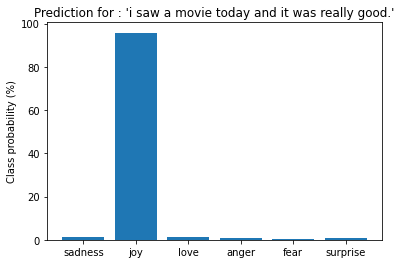

In [ ]:
plt.bar(labels.names, 100 * probs, color="C0")
plt.title(f"Prediction for : '{custom_tweet}'")
plt.ylabel("Class probability (%)")

##Error Analysis

A simple, yet
powerful tool is to sort the validation samples by the model loss. When passing the label during
the forward pass, the loss is automatically calculated and returned. Below is a function that
returns the loss along with the predicted label.

In [ ]:
def forward_pass_with_label(batch):
  input_ids = torch.tensor(batch["input_ids"], device=device)
  attention_mask = torch.tensor(batch["attention_mask"], device=device)
  labels = torch.tensor(batch["label"], device=device)
  print(labels)

  with torch.no_grad():
    output = model(input_ids, attention_mask)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, labels, reduction="none")

  batch["predicted_label"] = pred_label.cpu().numpy()
  batch["loss"] = loss.cpu().numpy()
  return batch

Using the `DatasetDict.map` function once more, we apply the function to get the losses for
all the samples:

In [ ]:
emotions_encoded.reset_format()
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

tensor([0, 0, 2, 3, 1, 1, 1, 1, 1, 0, 3, 1, 0, 0, 0, 1], device='cuda:0')
tensor([0, 3, 2, 1, 4, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0], device='cuda:0')
tensor([1, 0, 0, 1, 0, 0, 3, 1, 2, 0, 0, 0, 3, 0, 0, 3], device='cuda:0')
tensor([2, 0, 0, 1, 1, 0, 1, 1, 3, 0, 0, 2, 2, 1, 0, 1], device='cuda:0')
tensor([1, 0, 0, 2, 4, 0, 1, 1, 1, 4, 2, 1, 0, 3, 0, 0], device='cuda:0')
tensor([0, 3, 3, 0, 3, 2, 1, 1, 2, 3, 3, 1, 2, 3, 4, 1], device='cuda:0')
tensor([3, 3, 2, 0, 3, 2, 2, 0, 1, 3, 0, 1, 0, 0, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0, 1, 0, 3, 3, 3, 1, 0, 2, 4, 4, 1, 0], device='cuda:0')
tensor([4, 0, 0, 1, 3, 0, 4, 4, 2, 1, 1, 0, 1, 0, 1, 3], device='cuda:0')
tensor([5, 2, 4, 2, 0, 2, 1, 4, 3, 1, 3, 1, 5, 3, 2, 0], device='cuda:0')
tensor([4, 3, 1, 0, 1, 5, 1, 4, 4, 0, 0, 5, 0, 1, 4, 1], device='cuda:0')
tensor([4, 0, 2, 2, 0, 3, 3, 1, 1, 3, 3, 0, 0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 4, 1, 4, 1, 3, 0, 4, 1, 0, 1, 3, 3], device='cuda:0')
tensor([1, 4, 0, 4, 1, 1, 0, 0, 0, 1, 

Finally, we create a DataFrame with the texts, losses, and the predicted/true labels.

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str, split="test")
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str, split="test"))

In [ ]:
df_test.head()

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.021769
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.021934
2,i feel like a faithful servant,love,love,0.428474
3,i am just feeling cranky and blue,anger,anger,0.029345
4,i can have for a treat or if i am feeling festive,joy,joy,0.022436


We can now easily sort the DataFrame by the losses in either ascending or descending order.

In [ ]:
df_test.sort_values(by=["loss"], ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.655755
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.384926
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.326014
1963,i called myself pro life and voted for perry w...,joy,sadness,5.279847
1950,i as representative of everything thats wrong ...,surprise,sadness,4.977571
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.878881
1801,i feel that he was being overshadowed by the s...,love,sadness,4.834704
1111,im lazy my characters fall into categories of ...,joy,fear,4.702950
1509,i guess this is a memoir so it feels like that...,joy,fear,4.630934
1274,i am going to several holiday parties and i ca...,joy,sadness,4.506275


We can clearly see that the model predicted some of the labels wrong. On the other hand it
seems that there are quite a few examples with no clear class which might be either mislabelled
or require an new class altogether. 

In particular, joy seems to be mislabelled several times. With
this information we can refine the dataset which often can lead to as much or more performance
gain as having more data or larger models!

In [ ]:
df_test.sort_values(by=["loss"], ascending=True).head(10)

,text,label,predicted_label,loss
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.016944
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.017046
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.017291
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.017595
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.017609
1310,i feel like an ungrateful asshole,sadness,sadness,0.017713
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.017856
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.018021
866,i feel quite jaded and unenthusiastic about li...,sadness,sadness,0.018029
76,i feel like im an unwelcome presence whenever ...,sadness,sadness,0.018094


We now know that the joy is sometimes mislabelled and that the model is most confident about
giving the label sadness. With this information we can make targeted improvements to our dataset and also keep an eye on the class the model seems to be very confident about.

In [ ]:
df_test.sort_values(by=["label"], ascending=True).head(10)

,text,label,predicted_label,loss
1447,i feeling so agitated right now,anger,anger,0.688883
1290,ive spent the last several days feeling irrita...,anger,anger,0.029656
1289,im feeling very distracted today,anger,anger,0.053064
1287,i feel resentful in that i sacrificed alot for...,anger,anger,0.030770
1284,i look in my wallet and i feel a cold chill,anger,anger,0.051482
1279,i am feeling so violent i just fucking shudder...,anger,anger,0.035331
234,im feeling less grumpy after that,anger,anger,0.031395
1277,i will just say that i feel jealous and angry,anger,anger,0.038462
1683,i had applied for a job and they had assured m...,anger,joy,3.749578
1275,i wake up every morning excited about breakfas...,anger,anger,0.037265


In [ ]:
# selecting the true and pred mismatch labels
true_pred_labels_mismatch = df_test[df_test["label"] != df_test["predicted_label"]]

In [ ]:
true_pred_labels_mismatch

,text,label,predicted_label,loss
17,i know what it feels like he stressed glaring ...,anger,sadness,1.198635
27,i feel as if i am the beloved preparing hersel...,joy,love,1.772280
35,i am feeling very blessed today that they shar...,joy,love,1.236907
55,i didn t feel accepted,joy,love,0.806654
72,i feel that this is important in itself the fa...,joy,sadness,1.316638
...,...,...,...,...
1963,i called myself pro life and voted for perry w...,joy,sadness,5.279847
1964,i feel vaguely cheated and a little amused,joy,anger,3.938705
1987,i feel im supposed to hate dams amp all the co...,joy,anger,1.259942
1993,i feel so tortured by it,anger,fear,0.855164


In [ ]:
true_pred_labels_mismatch.shape

(150, 4)

In [ ]:
len(true_pred_labels_mismatch)

150

So, we have 150 samples that are misclassified.

In [ ]:
# selecting the true and pred mismatch labels
true_pred_labels_mismatch = df_test.loc[df_test["label"] != df_test["predicted_label"]]
true_pred_labels_mismatch

,text,label,predicted_label,loss
17,i know what it feels like he stressed glaring ...,anger,sadness,1.198635
27,i feel as if i am the beloved preparing hersel...,joy,love,1.772280
35,i am feeling very blessed today that they shar...,joy,love,1.236907
55,i didn t feel accepted,joy,love,0.806654
72,i feel that this is important in itself the fa...,joy,sadness,1.316638
...,...,...,...,...
1963,i called myself pro life and voted for perry w...,joy,sadness,5.279847
1964,i feel vaguely cheated and a little amused,joy,anger,3.938705
1987,i feel im supposed to hate dams amp all the co...,joy,anger,1.259942
1993,i feel so tortured by it,anger,fear,0.855164


##Saving the Model

Finally, we want to save the model so we can reuse it in another session or later if we want to
put it in production. 

We can save the model together with the right tokenizer in the same folder:

In [ ]:
trainer.save_model("models/distilbert-emotion")

Saving model checkpoint to models/distilbert-emotion
Configuration saved in models/distilbert-emotion/config.json
Model weights saved in models/distilbert-emotion/pytorch_model.bin


In [ ]:
tokenizer.save_pretrained("models/distilbert-emotion")

tokenizer config file saved in models/distilbert-emotion/tokenizer_config.json
Special tokens file saved in models/distilbert-emotion/special_tokens_map.json


('models/distilbert-emotion/tokenizer_config.json',
 'models/distilbert-emotion/special_tokens_map.json',
 'models/distilbert-emotion/vocab.txt',
 'models/distilbert-emotion/added_tokens.json',
 'models/distilbert-emotion/tokenizer.json')

The NLP community benefits greatly from sharing pretrained and fine-tuned models, and
everybody can share their models with others via the Hugging Face Model Hub.